## Import NBER graph and add department data

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy.stats as stats
import nltk.metrics as nm
import editdistance
import re
import matplotlib.pyplot as plt
execfile("utils.py")
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Begin analysis

In [2]:
# Load merged department-author graph from file
# NBER graph contains coauthorship edges annotated with JEL codes 
path = '../save/authors_departments.graphml'
G = nx.read_graphml(path)

In [3]:
# Get List of JEL codes
e = G.edges(data=True)
jels = set(','.join([x[2]['jelcode'] for x in e]).split(','))
bigJels = getBigJELs(jels)

# Get List of Nodes
n = G.nodes()
ndf = pd.DataFrame(n, columns=['author'])

## Summarize a list of subgraphs 

In [4]:
# utility functions

def getExternalDegreeDist(subgraph, graph):
    degs = np.array(nx.degree(graph, subgraph.nodes()).values()) - np.array(nx.degree(subgraph, subgraph.nodes()).values())
    
    return np.histogram(degs, bins=max(degs))[0]

In [5]:
def getAvgExternalDegree(subgraph, graph):
    try: 
        gdegree = np.array(nx.degree(graph, subgraph.nodes()).values())
        sgdegree = np.array(nx.degree(subgraph, subgraph.nodes()).values())
        return np.nanmean(gdegree - sgdegree)
    except:
        return np.nan

In [6]:
def getWithinDegreeDist(subgraph):
    return nx.degree_histogram(subgraph)

In [30]:
# Summarize a set 
# For each graph in a list, compute Avg Degree, Avg Betweenness Centrality, 
# Number of Components,
# Number of Nodes, Longest Shortest Path, Total # of Papers, 
# Avg # of Papers per author, % of Papers within Dept, Rank

# For example, "kind" could be 'Institution', "entries" would be a list of institutions
def summGraphList(kind, entries, subgraphList, graph):
    df = pd.DataFrame()
    df['id']        = entries
    
    df['Subgraph']  = df.id.apply(lambda x: subgraphList[x])
    df['nNodes'] = df.Subgraph.apply(lambda x: len(x.nodes()))
    
    # Drop empty entries
    df = df[df.nNodes != 0]
    
    df['nWithinEdges'] = df.Subgraph.apply(lambda x: len(x.edges()))
    df['nExternalEdges'] = df.Subgraph.apply(lambda x: len(x.edges()))
        
    # degree distribution within the dept
    df['AvgWithinDegree'] = df.Subgraph.apply(lambda x: \
                                         np.mean(nx.degree(x, x.nodes()).values()))

    df['WithinDegreeDist'] = df.Subgraph.apply(lambda x: getWithinDegreeDist(x))
    df['WithinDegreeSkewness'] = df.WithinDegreeDist.apply(lambda x: stats.skew(x))
    
    # avg degree outside the department
    df['AvgExternalDegree'] = df.Subgraph.apply(lambda x: getAvgExternalDegree(x, graph))
    
    df['ExternalDegreeDist'] = df.Subgraph.apply(lambda x: getExternalDegreeDist(x, graph))
    df['ExternalDegreeSkewness'] = df.ExternalDegreeDist.apply(lambda x: stats.skew(x))

    # Summary stats for connected components
    df['nConnectedComponents'] = df.Subgraph.apply(lambda x: \
                                   len([c for c in nx.connected_components(x)]))
    df['AvgSizeConnectedComponent'] = df.Subgraph.apply(lambda x: \
                                         np.mean([len(c) for c in nx.connected_components(x)]))
    df['MaxSizeConnectedComponent'] = df.Subgraph.apply(lambda x: \
                                         np.max([len(c) for c in nx.connected_components(x)]))
  
    # betweenness - gonna be very computationally intensive
    # df['BetweennessDist'] = df.Graph.apply(lambda x: nx.betweenness_centrality(x))
    
    # clustering coefficients
    df['clusteringCoeff'] = df.Subgraph.apply(lambda x: nx.average_clustering(x))
    
    # rename id column 
    df.rename(columns={'id': kind})
    
    # export to latex
    all_cols     = df.columns
    exclude_cols = ['Subgraph','WithinDegreeDist','ExternalDegreeDist']
    export_cols  = list(set(all_cols) - set(exclude_cols))

    text = df[export_cols].to_latex(longtable = True, float_format=lambda x: "%.3f" % x)
    fn = "../save/%s_summtable.tex" % kind
    f = open(fn, 'w')
    f.write(text)
    f.close()
    return df

## Examine JEL subgraphs

In [8]:
# save coauthorship network for each JEL category
jelGraphs = {}
overwrite = 1
for currCode in bigJels:
    jelGraphs[currCode] = getBigJELSubgraph(G, currCode)
    if overwrite:
        nx.write_graphml(jelGraphs[currCode], '../save/jel' + currCode + '.graphml')

In [17]:
sgl = summGraphList('bigJel', list(bigJels), jelGraphs, G)
#jel = 'A'
#[e for e in G.edges(data=True) if jel in re.findall("[a-zA-Z]", e[2]['jelcode'][0])]

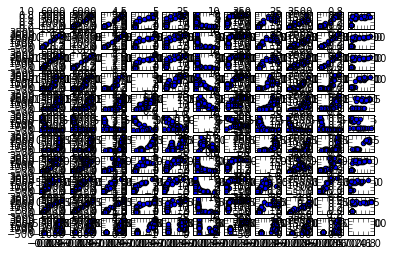

In [18]:
cols = [c for c in sgl.columns if 'id' not in c and 'Subgraph' not in c and 'Dist' not in c]
nCols = len(cols)

fig,ax = plt.subplots(nrows=nCols,ncols=nCols)

for i in range(nCols):
    for j in range(nCols):
        if i == j:
            continue
        else:
            ax[i,j].scatter(sgl[cols[i]], sgl[cols[j]])
            
            

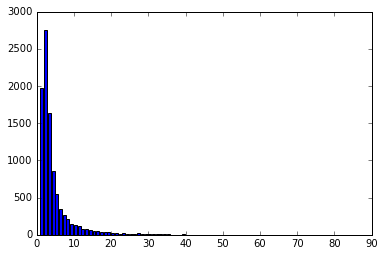

In [13]:
dd = nx.degree_histogram(G) 

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(np.arange(len(dd)),dd)
plt.show()

## Examine institutional subgraphs 

In [14]:
authDept = pd.read_csv('../save/authors_departments.csv', delimiter='|')

In [21]:
# Get list of NBER authors corresponding to Institution

instGraphs = {}
insts = authDept.Institution.unique()

# save coauthorship network for each institution
for currInst in insts:
    instGraphs[currInst] = G.subgraph(list(authDept[authDept.Institution == currInst].author))
    nx.write_graphml(instGraphs[currInst], \
                     '../save/' + currInst.replace(',','').replace(' ','_') + '.graphml')

In [31]:
# Summarize Institutional Graphs
sumInsts = summGraphList('Institution', insts, instGraphs, G)

In [32]:
sumInsts

,id,Subgraph,nNodes,nWithinEdges,nExternalEdges,AvgWithinDegree,WithinDegreeDist,WithinDegreeSkewness,AvgExternalDegree,ExternalDegreeDist,ExternalDegreeSkewness,nConnectedComponents,AvgSizeConnectedComponent,MaxSizeConnectedComponent,clusteringCoeff
0,"University of California, Davis CA","(ErichMuehlegger, AthanasiosGeromichalos, Paul...",27,16,16,1.185185,"[10, 9, 4, 2, 1, 1]",0.519354,9.296296,"[1, 6, 0, 1, 0, 4, 1, 3, 2, 3, 0, 0, 1, 0, 0, ...",3.043904,14,1.928571,7,0.180247
1,"Pennsylvania State University, State College PA","(NCoulson, DerekLaing, ShouyongShi, AGallant, ...",12,2,2,0.333333,"[9, 2, 1]",0.665469,8.583333,"[1, 2, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, ...",1.496834,10,1.200000,3,0.000000
2,"University of Michigan, Ann Arbor MI","(HoytBleakley, MelvinStephens, PaulRhode, Alan...",47,15,15,0.638298,"[28, 14, 2, 1, 1, 1]",1.158438,7.489362,"[2, 4, 6, 6, 6, 4, 2, 1, 1, 3, 1, 0, 2, 1, 0, ...",1.547186,34,1.382353,9,0.026950
3,"University of California, Berkeley CA","(DavidSraer, UlrikeMalmendier, GabrielZucman, ...",34,24,24,1.411765,"[11, 12, 4, 4, 0, 2, 1]",0.660470,14.823529,"[2, 3, 1, 3, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, ...",1.068328,16,2.125000,11,0.126471
4,"University of California, Los Angeles CA","(AndrewAtkeson, WilliamZame, JohnAsker, Edward...",23,9,9,0.782609,"[13, 4, 4, 2]",1.023753,7.347826,"[1, 2, 2, 4, 0, 1, 2, 0, 0, 1, 3, 1, 2, 1, 0, 3]",0.500914,15,1.533333,7,0.130435
5,"Johns Hopkins University, Baltimore MD","(LouisMaccini, OlivierJeanne, AntonKorinek, La...",12,5,5,0.833333,"[5, 5, 1, 1]",0.000000,6.583333,"[4, 0, 0, 1, 0, 0, 1, 0, 1, 2, 2, 0, 1]",1.393755,7,1.714286,4,0.000000
6,"Boston University, Boston MA","(RobertKing, DilipMookherjee, JamesRebitzer, F...",29,6,6,0.413793,"[21, 5, 2, 1]",1.044703,7.413793,"[1, 1, 5, 5, 3, 3, 0, 3, 0, 2, 2, 0, 0, 0, 1, ...",2.468531,24,1.208333,4,0.080460
7,"Yale University, New Haven CT","(LorenzoCaliendo, ChristopherUdry, CostasMeghi...",28,12,12,0.857143,"[11, 11, 5, 1]",-0.314270,10.607143,"[1, 3, 5, 0, 1, 1, 2, 3, 2, 2, 1, 1, 0, 0, 2, ...",1.855408,16,1.750000,5,0.000000
8,"University of Houston, Houston TX","(BentSrensen, BelgiTuran, AimeeChin, WillaFrie...",14,3,3,0.428571,"[10, 3, 0, 1]",0.906753,4.142857,"[3, 3, 2, 0, 2, 1, 1, 0, 1, 0, 1]",0.375203,11,1.272727,4,0.000000
9,"Princeton University, Princeton NJ","(RichardRogerson, StephenRedding, ChristopherN...",34,16,16,0.941176,"[16, 7, 8, 3]",0.600268,13.705882,"[3, 4, 1, 1, 0, 2, 0, 2, 2, 1, 2, 2, 0, 0, 1, ...",1.757517,18,1.888889,11,0.000000


In [ ]:
NBERPapers = pd.read_csv('../save/NBER_Paper_Info.1.csv', delimiter='|')

## Netflix feature matrix

- Pagerank
- JEL codes
- Geographic location (state, time zone) (prob time zone)
- Department

In [ ]:
# make a JEL lookup table to map jels to indices                                                     
jelLookup = dict()
for i, jel in enumerate(jels):
    jelLookup[jel] = i

# make an array of authors x JELs 
# to count how many papers in each JEL someone has
authors = nx.nodes(G)
authorCodes = np.zeros((len(authors), len(jels)))
for a in range(len(authors)):
    papers = G.edges(authors[a])
    for p in papers:
        paperAttrs = G.get_edge_data(p[0], p[1])
        paperJels  = paperAttrs['jelcode'].split(',')
        jelInds = [jelLookup[jel] for jel in paperJels]
        authorCodes[a, jelInds] += 1

In [ ]:
# PageRanks
ranks = nx.pagerank(G)

# add to graph                                                                  
nx.set_node_attributes(G, 'rank', ranks)

# in case we want to look at the top authors                                    
sortedRanks = sorted(ranks.items(), key=lambda x: x[1])

In [ ]:
# Extract PageRank to a vector                                                  
authors = G.nodes()
nodeRanks = np.empty(len(authors))
for i in range(len(authors)):
    nodeRanks[i] = ranks.get(authors[i])
nodeRanks = np.reshape(nodeRanks, (len(nodeRanks),1))

In [ ]:
# make feature dataframe
data = np.hstack((nodeRanks,authorCodes))
df = pd.DataFrame(data)
df.columns = ['rank'] + [jel for jel in jels]
df['author'] = authors

In [ ]:
df

In [ ]:
G.nodes(1)

#### TODO 

- Aggregate JELs by letter 
- Add JELS as author attributes.
- Look at degree distribution of subgraphs given by each JEL code